# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [34]:
#!nvidia-smi

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import cv2
import datetime
import os
import imageio
from skimage.transform import resize, rescale
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())
num_classes = 5  #number of softmax classes

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [5]:
#Plotting graph of loss and accuracy
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [6]:
#Function to calculate steps
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [7]:
#Function for callbacks
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


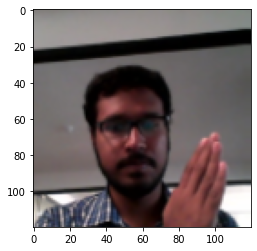

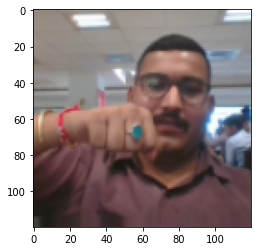

In [8]:
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

## Test code start
#360 by 360
image1 = imageio.imread("/datasets/Project_data/val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00015.png")
#160 by 120
image2 = imageio.imread("/datasets/Project_data/val/WIN_20180907_15_38_42_Pro_Thumbs Up_new/WIN_20180907_15_38_42_Pro_00007.png")
#crop the images and resize them. Note that the images are of 2 different shape
#and the conv3D will throw error if the inputs in a batch have different shapes
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)
plt.imshow(image2)
plt.show()

In [9]:
def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches =  len(t)//batch_size # calculate the number of batches
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int)#create a list of image numbers you want to use for a particular video
        #print(img_idx)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,num_images, height, width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                #print(imgs)
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                #print(idx,item)
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    if augment:
                      if np.random.randn() > 0:
                        image = datagen.random_transform(image)

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255#normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
          remaining_batch_size = len(t)%batch_size
          batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3))
          batch_labels = np.zeros((remaining_batch_size,5))
          for folder in range(remaining_batch_size):
            imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
              image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
              h, w, c = image.shape
              image = resize(image, (height, width), anti_aliasing=True)
              if augment:
                if np.random.randn() > 0:
                  image = datagen.random_transform(image)

                  batch_data[folder,idx,:,:,0] = (image[...,0])/255
                  batch_data[folder,idx,:,:,1] = (image[...,1])/255
                  batch_data[folder,idx,:,:,2] = (image[...,2])/255

            batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
          yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,LSTM
from keras.layers import Conv3D, MaxPooling3D,Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):
   model = Sequential()
   model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
   model.add(Activation('relu'))
   model.add(BatchNormalization())
   model.add(MaxPooling3D(pool_size=(2, 2, 2)))

   model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
   model.add(Activation('relu'))
   model.add(BatchNormalization())
   model.add(MaxPooling3D(pool_size=(2, 2, 2)))

   model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
   model.add(Activation('relu'))
   model.add(BatchNormalization())
   model.add(MaxPooling3D(pool_size=(2, 2, 2)))

   model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))
   model.add(Activation('relu'))
   model.add(BatchNormalization())
   model.add(MaxPooling3D(pool_size=(2, 2, 2)))

   model.add(Flatten())
   model.add(Dense(dense_nodes[0]))
   model.add(Activation('relu'))
   model.add(BatchNormalization())
   model.add(Dropout(dropout))

   model.add(Dense(dense_nodes[1]))
   model.add(Activation('relu'))
   model.add(BatchNormalization())
   model.add(Dropout(dropout))

   model.add(Dense(num_classes))
   model.add(Activation('softmax'))

   opt = tf.optimizers.Adam() #write your optimizer
   model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

   return model

### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [45]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_14 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                            

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [46]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [47]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                             callbacks=callbacks_list, validation_data=val_generator,
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 10


/tmp/ipykernel_294/1552239351.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/25


2024-07-07 09:51:29.761280: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.6286 - categorical_accuracy: 0.4314Source path =  /datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 3.19113, saving model to model_conv3D_1_2024-07-0709_51_24.075897/model-00001-1.62861-0.43137-3.19113-0.18000.h5
67/67 [==============================] - 186s 3s/step - loss: 1.6286 - categorical_accuracy: 0.4314 - val_loss: 3.1911 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.2428 - categorical_accuracy: 0.5173
Epoch 00002: val_loss did not improve from 3.19113
67/67 [==============================] - 176s 3s/step - loss: 1.2428 - categorical_accuracy: 0.5173 - val_loss: 10.0945 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.0747 - categorical_accuracy: 0.5656
Epoch 00003: val_loss did not improve from 3.19113
67/67 [==============================] -

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


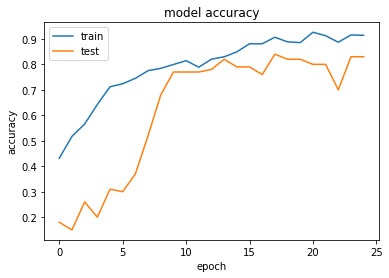

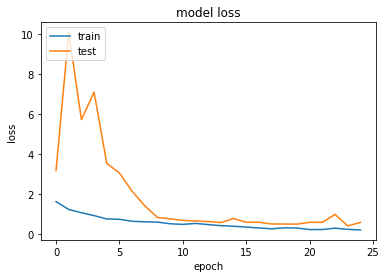

In [48]:
plot_loss_accuracy(history)

### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [49]:
num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 20
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_21 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 activat

In [50]:
callbacks_list = model_callbacks("model_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [51]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 10


/tmp/ipykernel_294/3067023477.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.6164 - categorical_accuracy: 0.4510Source path =  /datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 3.04837, saving model to model_conv3D_2_2024-07-0709_51_24.075897/model-00001-1.61635-0.45098-3.04837-0.17000.h5
67/67 [==============================] - 107s 2s/step - loss: 1.6164 - categorical_accuracy: 0.4510 - val_loss: 3.0484 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.3588 - categorical_accuracy: 0.4706
Epoch 00002: val_loss improved from 3.04837 to 2.49263, saving model to model_conv3D_2_2024-07-0709_51_24.075897/model-00002-1.35880-0.47059-2.49263-0.25000.h5
67/67 [==============================] - 108s 2s/step - loss: 1.3588 - categorical_accuracy: 0.4706 - val_loss: 2.4926 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.1462 - c

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


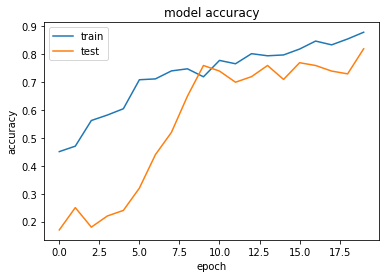

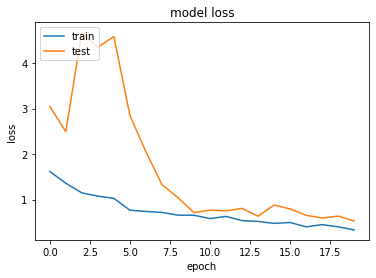

In [52]:
plot_loss_accuracy(history)

###  Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)

In [53]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 30
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 80, 80, 32)    13856     
                                                            

In [54]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [55]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 10


/tmp/ipykernel_294/3067023477.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.5765 - categorical_accuracy: 0.4359Source path =  /datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 2.47178, saving model to model_conv3D_3_2024-07-0709_51_24.075897/model-00001-1.57647-0.43590-2.47178-0.28000.h5
67/67 [==============================] - 203s 3s/step - loss: 1.5765 - categorical_accuracy: 0.4359 - val_loss: 2.4718 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.1373 - categorical_accuracy: 0.5656
Epoch 00002: val_loss did not improve from 2.47178
67/67 [==============================] - 176s 3s/step - loss: 1.1373 - categorical_accuracy: 0.5656 - val_loss: 9.4377 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.9321 - categorical_accuracy: 0.6561
Epoch 00003: val_loss did not improve from 2.47178
67/67 [=======================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


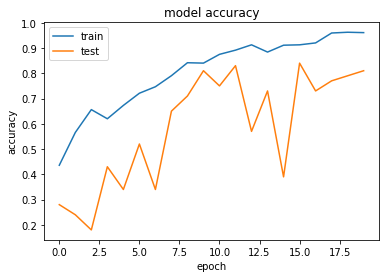

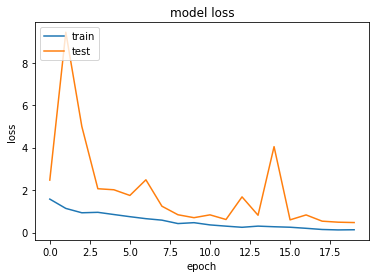

In [56]:
plot_loss_accuracy(history)

### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)

In [57]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_35 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                            

In [58]:
callbacks_list = model_callbacks("model_conv3D_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [59]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 10


/tmp/ipykernel_294/3067023477.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.6967 - categorical_accuracy: 0.3710Source path =  /datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 4.89322, saving model to model_conv3D_4_2024-07-0709_51_24.075897/model-00001-1.69670-0.37104-4.89322-0.34000.h5
67/67 [==============================] - 120s 2s/step - loss: 1.6967 - categorical_accuracy: 0.3710 - val_loss: 4.8932 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.2669 - categorical_accuracy: 0.5219
Epoch 00002: val_loss improved from 4.89322 to 4.61141, saving model to model_conv3D_4_2024-07-0709_51_24.075897/model-00002-1.26691-0.52187-4.61141-0.28000.h5
67/67 [==============================] - 117s 2s/step - loss: 1.2669 - categorical_accuracy: 0.5219 - val_loss: 4.6114 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.1191 - c

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


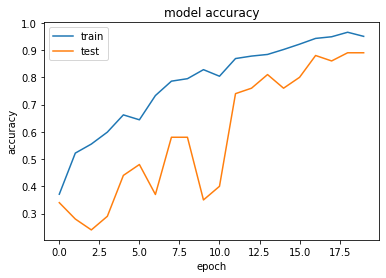

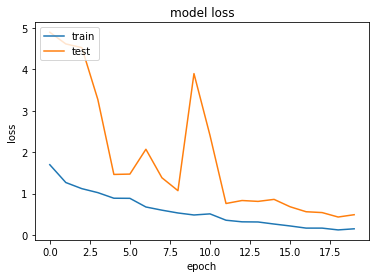

In [60]:
plot_loss_accuracy(history)

### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer) + Random data transformations on training data set

In [22]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_2 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                            

In [23]:
callbacks_list = model_callbacks("model_conv3D_5")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [24]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_203/3067023477.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 10
Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.6447 - categorical_accuracy: 0.4193Source path =  /datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 2.93373, saving model to model_conv3D_5_2024-07-0800_39_37.727019/model-00001-1.64470-0.41931-2.93373-0.25000.h5
67/67 [==============================] - 204s 3s/step - loss: 1.6447 - categorical_accuracy: 0.4193 - val_loss: 2.9337 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.2340 - categorical_accuracy: 0.5128
Epoch 00002: val_loss did not improve from 2.93373
67/67 [==============================] - 184s 3s/step - loss: 1.2340 - categorical_accuracy: 0.5128 - val_loss: 3.5470 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 1.1700 - categorical_accuracy: 0.5551
Epoch 00003: val_lo

In [ ]:
plot_loss_accuracy(history)

### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 128 dense layer + 64 dense layer + image size 120 by 120)

In [12]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (16, 32, 64, 128)
dense_filters = (128, 64)
model = conv3D(conv_filters=conv_filters, dense_nodes=dense_filters, dropout=0.2, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                              

2024-07-07 14:09:22.872799: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-07-07 14:09:22.872872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22849 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:41:00.0, compute capability: 7.5


In [13]:
callbacks_list = model_callbacks("model_conv3D_6")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=False, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [14]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_202/3067023477.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 10
Epoch 1/25


2024-07-07 14:09:49.398148: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.5319 - categorical_accuracy: 0.4284Source path =  /datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 3.11745, saving model to model_conv3D_6_2024-07-0714_08_00.344213/model-00001-1.53193-0.42836-3.11745-0.23000.h5
67/67 [==============================] - 180s 3s/step - loss: 1.5319 - categorical_accuracy: 0.4284 - val_loss: 3.1175 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.1673 - categorical_accuracy: 0.5370
Epoch 00002: val_loss did not improve from 3.11745
67/67 [==============================] - 163s 2s/step - loss: 1.1673 - categorical_accuracy: 0.5370 - val_loss: 5.0327 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.9957 - categorical_accuracy: 0.6124
Epoch 00003: val_loss did not improve from 3.11745
67/67 [==============================] - 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


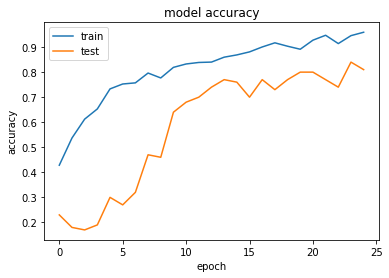

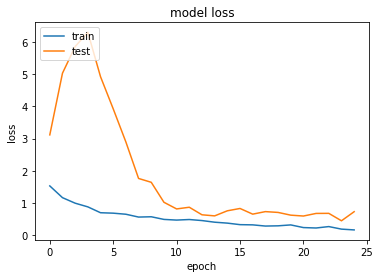

In [15]:
plot_loss_accuracy(history)

## TRANSFER LEARNING - MobileNet Conv2d + GRU


In [13]:
from keras.applications import mobilenet

def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = tf.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

### Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes


In [17]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True)
print (model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
17235968/17225924 [==============================] - 2s 0us/step
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 1024)         0         
 trib

In [18]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [19]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 10


/tmp/ipykernel_202/3067023477.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.1418 - categorical_accuracy: 0.5264Source path =  /datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 0.86932, saving model to model_retrain_mobilenet_gru_2024-07-0714_08_00.344213/model-00001-1.14183-0.52640-0.86932-0.62000.h5
67/67 [==============================] - 110s 2s/step - loss: 1.1418 - categorical_accuracy: 0.5264 - val_loss: 0.8693 - val_categorical_accuracy: 0.6200 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.5285 - categorical_accuracy: 0.8281
Epoch 00002: val_loss improved from 0.86932 to 0.57973, saving model to model_retrain_mobilenet_gru_2024-07-0714_08_00.344213/model-00002-0.52846-0.82805-0.57973-0.79000.h5
67/67 [==============================] - 106s 2s/step - loss: 0.5285 - categorical_accuracy: 0.8281 - val_loss: 0.5797 - val_categorical_accuracy: 0.7900 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


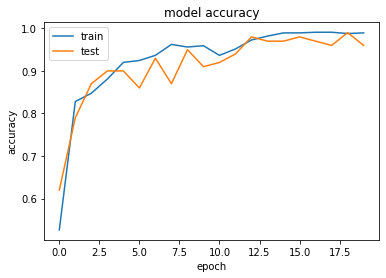

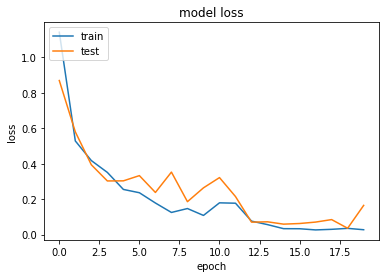

In [20]:
plot_loss_accuracy(history)

### Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set

In [21]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(gru=True, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 30
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 30, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 30, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
    

In [22]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [23]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 10


/tmp/ipykernel_202/3067023477.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.2868 - categorical_accuracy: 0.4766Source path =  /datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 0.92837, saving model to model_retrain_mobilenet_gru_2024-07-0714_08_00.344213/model-00001-1.28684-0.47662-0.92837-0.68000.h5
67/67 [==============================] - 197s 3s/step - loss: 1.2868 - categorical_accuracy: 0.4766 - val_loss: 0.9284 - val_categorical_accuracy: 0.6800 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.6177 - categorical_accuracy: 0.7707
Epoch 00002: val_loss improved from 0.92837 to 0.41991, saving model to model_retrain_mobilenet_gru_2024-07-0714_08_00.344213/model-00002-0.61770-0.77074-0.41991-0.87000.h5
67/67 [==============================] - 179s 3s/step - loss: 0.6177 - categorical_accuracy: 0.7707 - val_loss: 0.4199 - val_categorical_accuracy: 0.8700 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


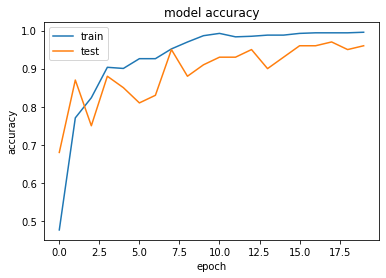

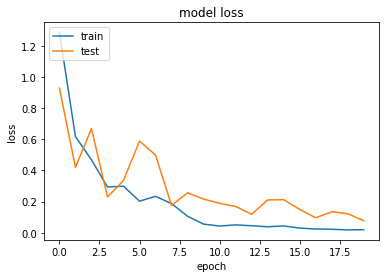

In [24]:
plot_loss_accuracy(history)

### Mobilenet (fine tune) + GRU (128 cells) + 128 dense nodes

In [25]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=True, gru=True, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 20, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
    

In [26]:
callbacks_list = model_callbacks("model_finetune_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [27]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 10


/tmp/ipykernel_202/3067023477.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 0.3683 - categorical_accuracy: 0.8612
Epoch 00003: val_loss improved from 0.78091 to 0.39299, saving model to model_finetune_mobilenet_gru_2024-07-0714_08_00.344213/model-00003-0.36830-0.86124-0.39299-0.84000.h5
67/67 [==============================] - 106s 2s/step - loss: 0.3683 - categorical_accuracy: 0.8612 - val_loss: 0.3930 - val_categorical_accuracy: 0.8400 - lr: 0.0010
Epoch 4/20
67/67 [==============================] - ETA: 0s - loss: 0.2336 - categorical_accuracy: 0.9201
Epoch 00004: val_loss improved from 0.39299 to 0.34856, saving model to model_finetune_mobilenet_gru_2024-07-0714_08_00.344213/model-00004-0.23356-0.92006-0.34856-0.86000.h5
67/67 [==============================] - 104s 2s/step - loss: 0.2336 - categorical_accuracy: 0.9201 - val_loss: 0.3486 - val_categorical_accuracy: 0.8600 - lr: 0.0010
Epoch 5/20
67/67 [==============================] - ETA: 0s - loss: 0.2191 - categorical_accuracy: 0.9351


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


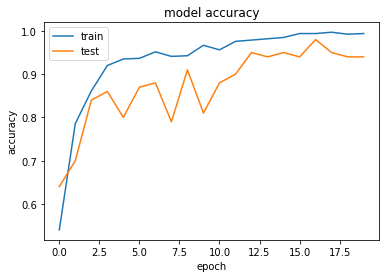

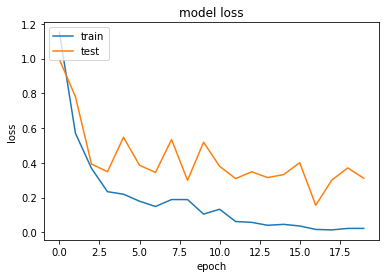

In [28]:
plot_loss_accuracy(history)

### Mobilenet (re train all wieghts) + LSTM (128 cells) + 128 dense nodes

In [25]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=False, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 20, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
    

In [26]:
callbacks_list = model_callbacks("model_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [27]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_203/3067023477.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.2904 - categorical_accuracy: 0.4510Source path =  /datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.10959, saving model to model_retrain_mobilenet_lstm_2024-07-0800_39_37.727019/model-00001-1.29038-0.45098-1.10959-0.57000.h5
67/67 [==============================] - 136s 2s/step - loss: 1.2904 - categorical_accuracy: 0.4510 - val_loss: 1.1096 - val_categorical_accuracy: 0.5700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.8318 - categorical_accuracy: 0.7059
Epoch 00002: val_loss improved from 1.10959 to 0.74296, saving model to model_retrain_mobilenet_lstm_2024-07-0800_39_37.727019/model-00002-0.83183-0.70588-0.74296-0.71000.h5
67/67 [==============================] - 115s 2s/step - loss: 0.8318 - categorical_accuracy: 0.7059 - val_loss: 0.7430 - val_categorical_accuracy: 0.7100 -

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


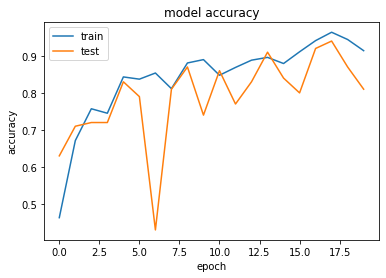

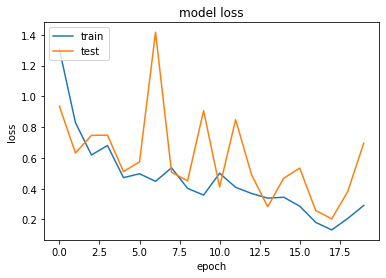

In [17]:
plot_loss_accuracy(history)

### Mobilenet (re train all weights) + 64 dense nodes + on training data set + Random data transformations

In [18]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=False, num_images=num_frames, lstm_gru_cells=128, dense_nodes=64)
print(model.summary())

# epochs = 15
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 20, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
    

In [19]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru_64")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [20]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 10


/tmp/ipykernel_203/3067023477.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.2213 - categorical_accuracy: 0.5008Source path =  /datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.01980, saving model to model_retrain_mobilenet_gru_64_2024-07-0800_39_37.727019/model-00001-1.22132-0.50075-1.01980-0.55000.h5
67/67 [==============================] - 122s 2s/step - loss: 1.2213 - categorical_accuracy: 0.5008 - val_loss: 1.0198 - val_categorical_accuracy: 0.5500 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 0.7773 - categorical_accuracy: 0.7164
Epoch 00002: val_loss improved from 1.01980 to 0.69588, saving model to model_retrain_mobilenet_gru_64_2024-07-0800_39_37.727019/model-00002-0.77731-0.71644-0.69588-0.73000.h5
67/67 [==============================] - 116s 2s/step - loss: 0.7773 - categorical_accuracy: 0.7164 - val_loss: 0.6959 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 3/15
67/67 [============================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


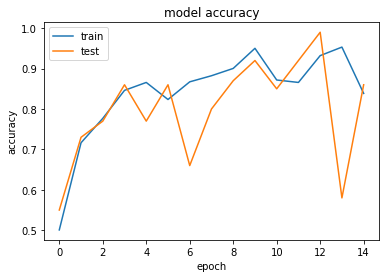

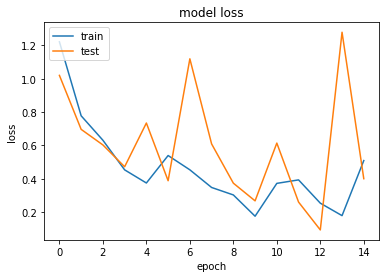

In [21]:
plot_loss_accuracy(history)